# Credit Card Customer Churn Analysis

Hello There!! Been a long time since I uploaded anything, might have some rough edges, apologies for that, do point out any issues in comments.

So this Dataset really drew my attention in last few days, as someone working in Finance, it seemed really intreasting to look into, and man did I enjoy working on it...

So the basic idea is as below.

<I><b>Business manager of a consumer credit card portfolio of a bank is facing severe customer attrition problem in the recent months. This is impacting the business. The business manager wants to leverage the power of data analytics to understand the primary reasons of attrition. She also wants to have an ability to understand the customers who are likely to close their accounts with the bank in near future, so that she can focus her efforts, well in advance to retain those customers.</b></I>

So lets put on our analytics hats and help out our friend here, below are the steps and we will try to find a viable solution to this guys problem in the smallest amount of time possible, dont wanna spend entire day here do we.

<h4>
<ol>
    <li>Data Loading</li>
    <li>Data Cleaning</li>
    <li>Univariant Analysis</li>
    <li>Multivariant Analysis</li>
    <li>Feature Engineering</li>
    <li>Model Development</li>
    <li>Results Analysis</li>
    <li>Conclusion</li>
</ol>
</h4>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics as mtr

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [ ]:
df = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns")

df.head(5)

## Data Cleaning

In [ ]:
# Lets drop 2 unnessecery columns, or probably very useful,who know!!
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1)

In [ ]:
# Lets get info on columns
df.info()

In [ ]:
print("Nubmber of Duplicate Rows: ",df.duplicated().sum())

In [ ]:
print(f"How pure is primary key 'CLIENTNUM': {len(df['CLIENTNUM'].unique())/len(df) * 100}%")

#### No Null, No Duplicates, No Overlapping keys, this is what analytics heaven must feel like

## Univariant Analysis

In [ ]:
# Function to get Descriptive Analysis of Numeric columns
def Numeric_Analysis(x):
    print('='*40)
    print(f'Descriptive Statistics of {x.name}')
    print('='*40)
    print(x.describe())
    print('='*40)
    print(f"Probability Density Plot for {x.name}")
    print('='*40)
    ax,fig = plt.subplots(figsize=(8,4))
    fig = sns.kdeplot(x.values,shade=True)
    fig = plt.xlabel(x.name)
    plt.show()

# Function to get Descriptive Analysis of Categorical columns
def Categorical_Analysis(x):
    print('='*40)
    print(f'One-Way Frequency Table of {x.name}')
    print('='*40)
    desc = pd.DataFrame(x.value_counts())
    desc.columns = ['Frequency']
    desc['Percentage'] = np.round((x.value_counts()/len(df) * 100).values,3)
    print(desc)
    print('='*40)
    fig,ax = plt.subplots(figsize=(8,6))
    print(f'One-Way Frequency Plot of {x.name}')
    print('='*40)
    fig = sns.barplot(x=desc.index,y=desc['Percentage'].values)
    fig.plot()
    fig = plt.ylabel('Percentage')
    fig = plt.xlabel(x.name)
    plt.show()

In [ ]:
for col, dtyp in dict(df.drop(['CLIENTNUM'], axis=1).dtypes).items():
    if dtyp.str == '|O':
        Categorical_Analysis(df[col])
    else:
        Numeric_Analysis(df[col])
    print("X--------------X"*6,)

## Insigts of Data From Descriptive Analysis

<ul>
    <li><b>CLIENTNUM: </b>Primary Key, No duplicates Not of much use as of now</li>
    <li><b>Attrition_Flag: </b>Target Feature, Categorical, Very unbalanced distribution of data, will see if we can use some kind of sampling technique to improve</li>
    <li><b>Customer_Age: </b>Discret Numerical Feature, I was expecting a skewd distribution, as older population are more prone to avoid using credit cards then the younger one.</li>
    <li><b>Gender: </b>Not being sexist, but its a little weird that there are more 'Female' Card holders than 'Men'.</li>
    <li><b>Dependent_count: </b>Discret Numerical Feature, an average family of 4 or less seems to be the case.</li>
    <li><b>Education: </b>Categorical Feature, gradutes seems to be most represented category, we might be able to combine a few categories into one based on there bad rate.</li>
    <li><b>Marital_Status: </b>Married people seems to be most represented here, it is possible that one customer might have more than one card in family, and drop a few to reduce liability</li>
    <li><b>Income_Category :</b>It is already binned, which causes some loss of info, and also I expected normal distribution, but it seems to be linear descending distribution as income increases.</li>
    <li><b>Card_Category :</b>Blue is overally dominant here, and others are way to small to add any useful info, we might drop this</li>
    <li><b>Months_on_book :</b>Normally distributed as expected, except for that weird peak, which might suggest tampering with original data, probably someone replace missing values with mean of data, causing such peak at mean, this is not good.</li>
    <li><b>Total_Relationship_Count :</b>Number of products owned by customer, we will see how it relates with attrition.</li>
    <li><b>Months_Inactive_12_mon :</b>It seems Inactivie users mostly comeback after 3 months max or probably drop out, a good hypothisis to check.</li>
    <li><b>Contacts_Count_12_mon :</b>Very similar to last column, as most people comeback by 3 months, most contact is done during that period to bring user back to spending, its possible that users who do not respond even after 3 months are more probable to drop off permanently</li>
    <li><b>Credit_Limit :</b>Has a weird bump at the end of the tail, worth checking further.</li>
    <li><b>Total_Revolving_Bal :</b> Total Revolving balance means, how much balance is left over after each last payment made by customer, or pending debt, seems most people payoff there debt or have none, but a large portion seems to carry a huge amount.</li>
    <li><b>Avg_Open_To_Buy :</b>Average open credit line over last 12 months, distribution very similar to credit_limit, might be correlated and thus redundunt</li>
    <li><b>Total_Amt_Chng_Q4_Q1 :</b>Not quite sure what it means, perhaps the percentage change in last 1 year in overall balance.</li>
    <li><b>Total_Trans_Amt :</b>Very uneven distribution,  perhaps will work better if we just bin it.</li>
    <li><b>Total_Trans_Ct :</b>A double hump  camel, this tells us there are high frequency users and low frequency users in our data, usually its the low frequency users who sticks with a bank longer, as they have less issues with there cards.</li>
    <li><b>Total_Ct_Chng_Q4_Q1 :</b>Not quite sure what this is, lets assume its point change in total transaction count</li>
    <li><b>Avg_Utilization_Ratio :</b>Card Utilization Ratio is debt/credit_limit at any given time,I am asummin the average is over 12 months, which would simply be<b> (Credit_Limit - Avg_Open_To_Buy)/Credit_Limit)</b> seems we already have some engineered columns here</li>
</ul>

#### This data seems heavely modified and engineered already, we must carefully avoid the trap of multicollinearity

## Multivariant Analysis

In [ ]:
num_cols = [col for col in df.drop(['CLIENTNUM','Attrition_Flag'], axis=1).columns if df[col].dtype.str != '|O']
cat_cols = [col for col in df.drop(['CLIENTNUM','Attrition_Flag'], axis=1).columns if df[col].dtype.str == '|O']

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
fig = sns.heatmap(df[num_cols].corr(), fmt='.1', cmap='Reds', annot=True)
fig = plt.xticks(rotation=70)

<h3>Insights:</h3>

<ul>
    <li><b>Months_on_books-vs-Customer_Age:</b> The older the customer, the longer they have been with company, very strongly correlated, either have to drop one or find a way to combine that</li>
    <li><b>Credit_Limit -vs- Average_Open_To_Buy: </b> As expected, this is way similar as credit_limit, we can just drop one of the columns.</li>
    <li><b>Total_Trans_Amt -vs- Total_Trans_Ct: </b>The more transactions you do, the more amount you generate in debt, no surprise there.</li>
</ul>

In [ ]:
# Getting Cramer's V for Categorical Correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
n = len(cat_cols)
cat_corr = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        cat_corr[i,j] = cramers_v(df[cat_cols[i]],df[cat_cols[j]])

cat_corr = pd.DataFrame(cat_corr, index=cat_cols, columns=cat_cols)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
fig = sns.heatmap(cat_corr, fmt='.2', cmap='Reds', annot=True)
fig = plt.yticks(rotation=0)

In [ ]:
pd.crosstab(df['Gender'],df['Income_Category'], margins='row')

<h3>Insights</h3>

No major correlation, other than <b>"Income_Category -vs- Gender"</b>,although majority of card holders are females, there income category is mostly on lower end, or unknonw. We will have to find a way to combine the two columns, to avoid unstable models.

## Feature Engineering

In [ ]:
# Combine the Customer_Age and Months_on_book to get a new column so we can drop one of them and avoid correlation
Per_of_life_as_cust = df['Months_on_book']/(df['Customer_Age']*12) * 100
df['Per_of_life_as_cust'] = Per_of_life_as_cust
df[['Customer_Age','Per_of_life_as_cust']].corr()

In [ ]:
# Average Transaction amount gives us a better feature and also avoids correlation
Avg_Trans_Amt = df['Total_Trans_Amt']/df['Total_Trans_Ct']
df['Avg_Trans_Amt'] = Avg_Trans_Amt
df[['Avg_Trans_Amt','Total_Trans_Ct']].corr()

In [ ]:
df = df.drop(['Total_Trans_Amt','Months_on_book','Avg_Open_To_Buy','Card_Category'], axis=1)

In [ ]:
X = df.drop(['CLIENTNUM','Attrition_Flag'], axis=1).copy()
y = (df['Attrition_Flag'].copy() == 'Attrited Customer')*1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55, test_size=0.3)

In [ ]:
to_standardize = ['Customer_Age','Credit_Limit','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1','Total_Trans_Ct',
                  'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio','Per_of_life_as_cust','Avg_Trans_Amt']
to_woe = [col for col in X_train.columns if col not in to_standardize]

In [ ]:
ss = StandardScaler()
ss.fit(X_train[to_standardize])
X_train[to_standardize] = ss.transform(X_train[to_standardize])
X_test[to_standardize] = ss.transform(X_test[to_standardize])

### What is Weight of Evidence?

<b>The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who left company, and "Good Customers" refers to the customers who continued to use credit card.</b>

<b>Therefore a positive WOE mean more "Good Customers" than "Bad Customers", and vice versa for negative WOE. Absolute value of WOE tells us the seperation of two.</b>

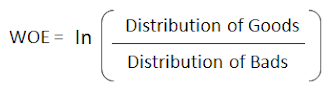

<b>We can replace the categorical features with there respective WOE, rather than using dummy variables. This helps us avoid increasing dimensionality of our data</b>

### What is IV?

<b>IV stands for Information Value, it is useful in determining the predictive power of a feature based on there class seperation, using WOE</b>

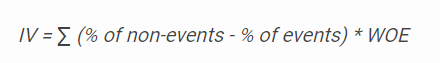

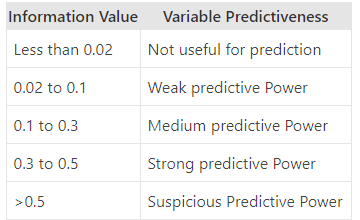

In [ ]:
target_flag = y_train == 1
N = len(y_train)
def WOE_Calculator(x):
    rows = list()
    #print(x.name)
    for attr in list(x.unique()):
        #print(attr)
        x_at = x[x == attr]
        n = len(x_at)
        good_per = (len(x_at[~target_flag])+0.5)/N * 100
        bad_per = (len(x_at[target_flag])+0.5)/N * 100
        woe = np.log(good_per/bad_per)
        iv = ((good_per - bad_per)/100)*woe
        rows.append([x.name, attr, n, good_per, bad_per, woe, iv])
    return pd.DataFrame(rows, columns=['Feature', 'Attribute', 'Count', 'Good%', 'Bad%', 'WOE', 'IV'])

In [ ]:
df_iv = pd.DataFrame(columns=['Feature', 'Attribute', 'Count', 'Good%', 'Bad%', 'WOE', 'IV'])
for col in X_train[to_woe].columns:
    df_iv = pd.concat([WOE_Calculator(X_train[col]), df_iv])

In [ ]:
df_iv.sort_values(by='WOE').head(10)

In [ ]:
df_iv.groupby('Feature')['IV'].sum()

In [ ]:
for col in X_train[to_woe].columns:
    woe_dict = dict(df_iv[df_iv['Feature'] == col][['Attribute','WOE']].set_index('Attribute')['WOE'])
    X_train[col] = X_train[col].apply(lambda x : woe_dict[x])
    X_test[col] = X_test[col].apply(lambda x : woe_dict[x])

## Model Development & Validation

In [ ]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print(mtr.classification_report(y_test, y_pred))
print('AUC of  ROC is : ',mtr.roc_auc_score(y_test, y_pred))
fig = sns.heatmap(mtr.confusion_matrix(y_test, y_pred), fmt='', cmap='Blues', annot=True)

### What is Gains Table

**Gains table are mostly used in scorecard based models to identify model performance across different probability score intervals. Gain is defined as cumalatve bad capture rate at any interval, in simple words,  if we set our threshold their such that any observation with probaility score higher is positive, what percentage of true postive we will be able to capture.**

In [ ]:
def gains_table(y_true, y_pred):
    y = pd.DataFrame(np.c_[y_true,y_pred[:,1]],columns=['y_true','y_pred']).sort_values(by='y_pred')
    y_true = y['y_true']
    y_pred = y['y_pred']
    n = len(y_true)
    y_pred = pd.Series(y_pred*100).sort_values(ascending=False)
    bins = [i for i in range(0,n-int(n/10),int(n/10))] + [n]
    rows = []
    cum_good = 0
    cum_bad = 0
    good_n = (y_true == 0).sum()
    bad_n = (y_true == 1).sum()
    for i in range(0,10):
        x = y_pred[bins[i]:bins[i+1]]
        max_prob = np.max(x)
        min_prob = np.min(x)
        mean_prob = np.mean(x)
        count = len(x)
        good = len(x[y_true == 0])
        bad = len(x[y_true == 1])
        good_per = np.round(good/count * 100,2)
        bad_per = np.round(bad/count * 100,2)
        cum_good = cum_good + good
        cum_bad = cum_bad + bad
        if bad == 0:
            fpr = np.inf
        else:
            fpr = good/bad
        cum_good_per = np.round(cum_good / good_n * 100,2)
        cum_bad_per = np.round(cum_bad / bad_n * 100,2)
        ks = cum_bad_per - cum_good_per
        rows.append([max_prob, mean_prob, min_prob, count, good, bad, good_per, bad_per,cum_good, cum_bad, fpr,
                     cum_good_per, cum_bad_per, ks])
    return pd.DataFrame(rows, columns=['Max Proba', 'Mean Proba', 'Min Proba', 'Count', 'Good', 'Bad', 'Good%', 'Bad%',
                                       'Cumalative Good', 'Cumalative Bad', 'False Positive Rate', 'Cumalative Good%',
                                       'Cumalative Bad%', 'KS'])

In [ ]:
y_pred_prob = clf.predict_proba(X_test)
gains_table(y_test.values, y_pred_prob)

In [ ]:
y_pred2 = (y_pred_prob[:,1] >= 0.11)*1

In [ ]:
print(mtr.classification_report(y_test, y_pred2))
print('AUC of  ROC is : ',mtr.roc_auc_score(y_test, y_pred2))
fig = sns.heatmap(mtr.confusion_matrix(y_test, y_pred2), fmt='', cmap='Blues', annot=True)

In [ ]:
model_coef = pd.Series(dict(zip(list(X_train.columns),list(clf.coef_[0])))).sort_values()
fig,ax = plt.subplots(figsize=(6,6))
fig = sns.barplot(x=model_coef.values, y=model_coef.index)